## Import Modules

In [1]:
import datetime
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

## Chromosome & fitness_function

In [2]:
class Chromosome:
    def __init__(self, genes, fitness):
        self.Genes = genes
        self.Fitness = fitness

def get_fitness(guess, target):
    fitness = 0
    for expected, actual in zip(target, guess):
        if expected == actual:
            fitness += 1
    return fitness

## Select Functions

In [3]:
def proportional_selection(parent_list):
    child_list = []
    fitness_percent_list = []
    fitness_accum_list = []
    fitness_sum = 0
    for parent in parent_list:
        fitness_sum += parent.Fitness

    for parent in parent_list:
        fitness_percent_list.append(parent.Fitness / fitness_sum)

    fitness_sum = 0
    for fitness_percent in fitness_percent_list:
        fitness_sum += fitness_percent
        fitness_accum_list.append(fitness_sum)

    for i in range(0, 10):
        rand = random.random()
        before = 0
        for j in range(0, len(fitness_accum_list)):
            if rand > before and rand <= fitness_accum_list[j]:
                child_list.append(copy.deepcopy(parent_list[j]))
                break
            before = fitness_accum_list[j]
    return child_list


def tournament_selection(parent_list, k):
    child_list = []
    for i in range(0, 10):
        sample_index = random.sample(range(0,10), k)
        max_fitness = 0
        max_index = sample_index[0]
        for j in sample_index:
            if parent_list[j].Fitness > max_fitness:
                max_fitness = parent_list[j].Fitness
                max_index = j
        winner_chromosome = parent_list[max_index]
        child_list.append(copy.deepcopy(winner_chromosome))
    return child_list

## Genetic Algorithm

In [4]:
def _generate_parent(length, geneSet, get_fitness):
    chromosome_list = []
    average = 0
    for i in range(0, 10):
        genes = []
        while len(genes) < length:
            sampleSize = min(length - len(genes), len(geneSet))
            genes.extend(random.sample(geneSet, sampleSize))
        fitness = get_fitness(genes)
        average += fitness
        chromosome_list.append(Chromosome(genes, fitness))
    return chromosome_list, average/length

def _mutate(parent, geneSet, get_fitness):
    childGenes = parent.Genes[:]
    index = random.randrange(0, len(parent.Genes))
    newGene, alternate = random.sample(geneSet, 2)
    childGenes[index] = alternate if newGene == childGenes[index] else newGene
    fitness = get_fitness(childGenes)
    return Chromosome(childGenes, fitness)

def _generate_child(parent_list, geneSet, get_fitness, parameters):
    child_list = []

    # Selection
    if parameters['select_type'] == 'proportionate': # proportionate Selection
        child_list = proportional_selection(parent_list)
    elif parameters['select_type'] == 'tournament': # tournament Selection
        child_list = tournament_selection(parent_list, parameters['tournament_k'])
    else:
        print("Invalid Select Type!")
        return []

    # Crossover (Single Point Crossover 사용, Crossover point: 5)
    selected = None
    for i in range(0, len(child_list)):
        rand = random.random()
        if rand < parameters['crossover_rate']:
            if selected is None:
                selected = i
            else:
                child_list[selected].Genes[parameters['crossover_point']:], child_list[i].Genes[parameters['crossover_point']:] = child_list[i].Genes[parameters['crossover_point']:], child_list[selected].Genes[parameters['crossover_point']:]
                selected = None

        # update
        child_list[i].Fitness = get_fitness(child_list[i].Genes)

    # mutate
    for i in range(0, len(child_list)):
        rand = random.random()
        if rand < parameters['mutate_rate']:
            child = _mutate(child_list[i], geneSet, get_fitness)
            del child_list[i]
            child_list.append(child)
    return child_list

def get_answer(get_fitness, targetLen, optimalFitness, geneSet, display, parameters):
    random.seed()
    
    # genration count, maximum_average, fit_history
    gen_count = 0
    maximum_average = 0
    avg_fitness_hist = []

    # Generate Parent
    bestParentList, average = _generate_parent(targetLen, geneSet, get_fitness)
    avg_fitness_hist.append(average)

    # Calculate Optimal Answer
    while True:
        gen_count += 1
        child_list = _generate_child(bestParentList, geneSet, get_fitness, parameters)

        fitness_sum = 0
        for child in child_list:
            fitness_sum += child.Fitness

        average = fitness_sum / 10
        avg_fitness_hist.append(average)

        if average > maximum_average:
            bestParentList = child_list
            maximum_average = average

        if average >= optimalFitness:
            return child_list, avg_fitness_hist

## English Test

In [5]:
def generate_answer(length, is_duplicate_allowed):
    # 중복이 허용되거나, length가 4 넘을 때 (1234 인데 길이 4가 넘으면 중복은 당연히 허용)
    random.seed()
    if is_duplicate_allowed is True or length > 4:
        return ''.join(random.choice("1234") for _ in range(length))
    
    answer_list = []
    num = random.randrange(1, 4)
    for i in range(length):
        while str(num) in answer_list:
            num = random.randrange(1, 4)
        answer_list.append(str(num))

    target = ''.join(answer_list)
    return target

def english_test(target, parameters):
    geneset = "1234"
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate_list):
        display_list(candidate_list, target, startTime)

    optimalFitness = len(target) * 1
    child_list, avg_fitness_hist = get_answer(fnGetFitness, len(target), optimalFitness, geneset, fnDisplay, parameters)

    # print("{} Selection, time: {}".format(parameters['select_type'], datetime.datetime.now() - startTime))
    return avg_fitness_hist

## Display Methods

In [6]:
def display(candidate, target, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t\t{}".format(''.join(candidate.Genes),candidate.Fitness,timeDiff))

def display_list(candidate_list, target, startTime):
    fitness_sum = 0
    print("{}\t\t{}\t\t{}".format('Answer', 'Fitness','Time'))
    for candidate in candidate_list:
        display(candidate, target, startTime)
        fitness_sum += candidate.Fitness
    # print("average fitness : {}".format(fitness_sum / len(candidate_list)))
    
def plot_result(values, title, legend, xlabel, ylabel):
    for value in values:
        plt.plot(range(0,len(value)), value)
    plt.title(title)
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Experiment I - Different selection type

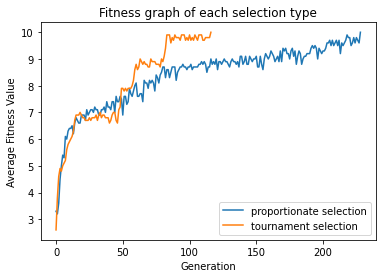

In [7]:
# Proportionate Selection Parameters
pSel_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}

# Tournament Seletion Parameters
tSel_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}

simulation_times = 100 # simulation times
pSel_fit_mid_hist =  []
tSel_fit_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    pSel_fit_hist = english_test(target, pSel_parameters)
    tSel_fit_hist = english_test(target, tSel_parameters)
    pSel_fit_mid_hist.append((pSel_fit_hist, len(pSel_fit_hist)))
    tSel_fit_mid_hist.append((tSel_fit_hist, len(tSel_fit_hist)))

pSel_fit_hist = sorted(pSel_fit_mid_hist, key=lambda x:x[1])[50][0]
tSel_fit_hist = sorted(tSel_fit_mid_hist, key=lambda x:x[1])[50][0]

plot_result(
    [pSel_fit_hist, tSel_fit_hist],
    'Fitness graph of each selection type',
    ['proportionate selection', 'tournament selection'],
    'Generation',
    'Average Fitness Value')


## Experiment II - Different mutate_rate in proportionate selection

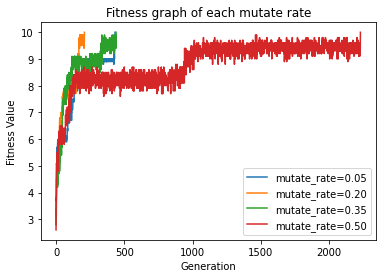

In [8]:
# mutate_rate = 0.05
mutate1_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.02
}
# mutate_rate = 0.20
mutate2_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# mutate_rate = 0.35
mutate3_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.35
}
# mutate_rate = 0.50
mutate4_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.50
}

simulation_times = 100 # simulation times
mutate1_mid_hist = []
mutate2_mid_hist = []
mutate3_mid_hist = []
mutate4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    mutate1_fit_hist = english_test(target, mutate1_parameters)
    mutate2_fit_hist = english_test(target, mutate2_parameters)
    mutate3_fit_hist = english_test(target, mutate3_parameters)
    mutate4_fit_hist = english_test(target, mutate4_parameters)
    
    mutate1_mid_hist.append((mutate1_fit_hist, len(mutate1_fit_hist)))
    mutate2_mid_hist.append((mutate2_fit_hist, len(mutate2_fit_hist)))
    mutate3_mid_hist.append((mutate3_fit_hist, len(mutate3_fit_hist)))
    mutate4_mid_hist.append((mutate4_fit_hist, len(mutate4_fit_hist)))

mutate1_fit_hist = sorted(mutate1_mid_hist, key=lambda x:x[1])[50][0]
mutate2_fit_hist = sorted(mutate2_mid_hist, key=lambda x:x[1])[50][0]
mutate3_fit_hist = sorted(mutate3_mid_hist, key=lambda x:x[1])[50][0]
mutate4_fit_hist = sorted(mutate4_mid_hist, key=lambda x:x[1])[50][0]

plot_result(
    [mutate1_fit_hist,mutate2_fit_hist,mutate3_fit_hist,mutate4_fit_hist],
    'Fitness graph of each mutate rate',
    ['mutate_rate=0.05', 'mutate_rate=0.20', 'mutate_rate=0.35', 'mutate_rate=0.50'],
    'Generation',
    'Fitness Value')

## Experiment II - Different mutate_rate in tournament selection

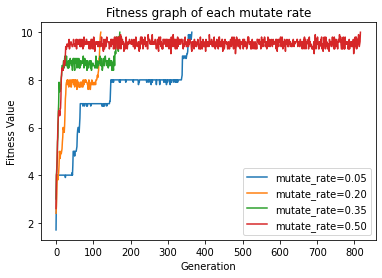

In [9]:
# mutate_rate = 0.05
mutate1_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.02
}
# mutate_rate = 0.20
mutate2_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# mutate_rate = 0.35
mutate3_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.35
}
# mutate_rate = 0.50
mutate4_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.50
}

simulation_times = 100 # simulation times
mutate1_mid_hist = []
mutate2_mid_hist = []
mutate3_mid_hist = []
mutate4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    mutate1_fit_hist = english_test(target, mutate1_parameters)
    mutate2_fit_hist = english_test(target, mutate2_parameters)
    mutate3_fit_hist = english_test(target, mutate3_parameters)
    mutate4_fit_hist = english_test(target, mutate4_parameters)
    
    mutate1_mid_hist.append((mutate1_fit_hist, len(mutate1_fit_hist)))
    mutate2_mid_hist.append((mutate2_fit_hist, len(mutate2_fit_hist)))
    mutate3_mid_hist.append((mutate3_fit_hist, len(mutate3_fit_hist)))
    mutate4_mid_hist.append((mutate4_fit_hist, len(mutate4_fit_hist)))

mutate1_fit_hist = sorted(mutate1_mid_hist, key=lambda x:x[1])[50][0]
mutate2_fit_hist = sorted(mutate2_mid_hist, key=lambda x:x[1])[50][0]
mutate3_fit_hist = sorted(mutate3_mid_hist, key=lambda x:x[1])[50][0]
mutate4_fit_hist = sorted(mutate4_mid_hist, key=lambda x:x[1])[50][0]

plot_result(
    [mutate1_fit_hist,mutate2_fit_hist,mutate3_fit_hist,mutate4_fit_hist],
    'Fitness graph of each mutate rate',
    ['mutate_rate=0.05', 'mutate_rate=0.20', 'mutate_rate=0.35', 'mutate_rate=0.50'],
    'Generation',
    'Fitness Value')

### Additional Experiment - Different crosspoint in proportionate selection

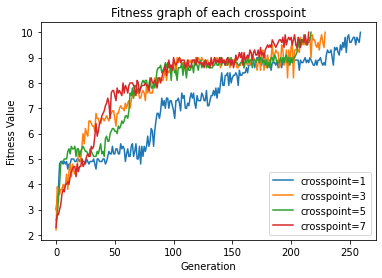

In [10]:
# crosspoint = 1
crosspoint1_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 1,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 3
crosspoint2_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 3,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 5
crosspoint3_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 7
crosspoint4_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 7,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}

simulation_times = 300 # simulation times
crosspoint1_mid_hist = []
crosspoint2_mid_hist = []
crosspoint3_mid_hist = []
crosspoint4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    crosspoint1_fit_hist = english_test(target, crosspoint1_parameters)
    crosspoint2_fit_hist = english_test(target, crosspoint2_parameters)
    crosspoint3_fit_hist = english_test(target, crosspoint3_parameters)
    crosspoint4_fit_hist = english_test(target, crosspoint4_parameters)
    
    crosspoint1_mid_hist.append((crosspoint1_fit_hist, len(crosspoint1_fit_hist)))
    crosspoint2_mid_hist.append((crosspoint2_fit_hist, len(crosspoint2_fit_hist)))
    crosspoint3_mid_hist.append((crosspoint3_fit_hist, len(crosspoint3_fit_hist)))
    crosspoint4_mid_hist.append((crosspoint4_fit_hist, len(crosspoint4_fit_hist)))

crosspoint1_fit_hist = sorted(crosspoint1_mid_hist, key=lambda x:x[1])[150][0]
crosspoint2_fit_hist = sorted(crosspoint2_mid_hist, key=lambda x:x[1])[150][0]
crosspoint3_fit_hist = sorted(crosspoint3_mid_hist, key=lambda x:x[1])[150][0]
crosspoint4_fit_hist = sorted(crosspoint4_mid_hist, key=lambda x:x[1])[150][0]

plot_result(
    [crosspoint1_fit_hist,crosspoint2_fit_hist,crosspoint3_fit_hist,crosspoint4_fit_hist],
    'Fitness graph of each crosspoint',
    ['crosspoint=1', 'crosspoint=3', 'crosspoint=5', 'crosspoint=7'],
    'Generation',
    'Fitness Value')

### Additional Experiment - Different crosspoint in tournament selection

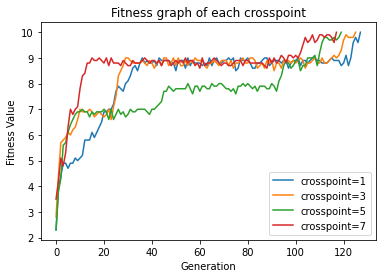

In [11]:
# crosspoint = 1
crosspoint1_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 1,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 3
crosspoint2_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 3,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 5
crosspoint3_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crosspoint = 7
crosspoint4_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 7,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}

simulation_times = 300 # simulation times
crosspoint1_mid_hist = []
crosspoint2_mid_hist = []
crosspoint3_mid_hist = []
crosspoint4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    crosspoint1_fit_hist = english_test(target, crosspoint1_parameters)
    crosspoint2_fit_hist = english_test(target, crosspoint2_parameters)
    crosspoint3_fit_hist = english_test(target, crosspoint3_parameters)
    crosspoint4_fit_hist = english_test(target, crosspoint4_parameters)
    
    crosspoint1_mid_hist.append((crosspoint1_fit_hist, len(crosspoint1_fit_hist)))
    crosspoint2_mid_hist.append((crosspoint2_fit_hist, len(crosspoint2_fit_hist)))
    crosspoint3_mid_hist.append((crosspoint3_fit_hist, len(crosspoint3_fit_hist)))
    crosspoint4_mid_hist.append((crosspoint4_fit_hist, len(crosspoint4_fit_hist)))

crosspoint1_fit_hist = sorted(crosspoint1_mid_hist, key=lambda x:x[1])[150][0]
crosspoint2_fit_hist = sorted(crosspoint2_mid_hist, key=lambda x:x[1])[150][0]
crosspoint3_fit_hist = sorted(crosspoint3_mid_hist, key=lambda x:x[1])[150][0]
crosspoint4_fit_hist = sorted(crosspoint4_mid_hist, key=lambda x:x[1])[150][0]

plot_result(
    [crosspoint1_fit_hist,crosspoint2_fit_hist,crosspoint3_fit_hist,crosspoint4_fit_hist],
    'Fitness graph of each crosspoint',
    ['crosspoint=1', 'crosspoint=3', 'crosspoint=5', 'crosspoint=7'],
    'Generation',
    'Fitness Value')

### Additional Experiment - Different crossover rate in proportionate selection

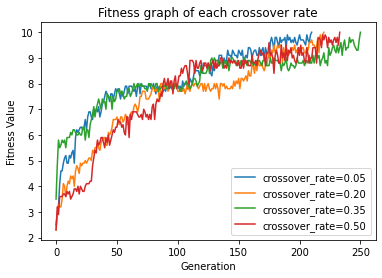

In [12]:
# crossover_rate = 0.05
crossover1_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.05,
    'mutate_rate': 0.20
}
# crossover_rate = 0.20
crossover2_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crossover_rate = 0.35
crossover3_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.35,
    'mutate_rate': 0.20
}
# crossover_rate = 0.50
crossover4_parameters = {
    'select_type': 'proportionate',
    'tournament_k': 3,
    'crossover_point': 7,
    'crossover_rate': 0.50,
    'mutate_rate': 0.20
}

simulation_times = 300 # simulation times
crossover1_mid_hist = []
crossover2_mid_hist = []
crossover3_mid_hist = []
crossover4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    crossover1_fit_hist = english_test(target, crossover1_parameters)
    crossover2_fit_hist = english_test(target, crossover2_parameters)
    crossover3_fit_hist = english_test(target, crossover3_parameters)
    crossover4_fit_hist = english_test(target, crossover4_parameters)
    
    crossover1_mid_hist.append((crossover1_fit_hist, len(crossover1_fit_hist)))
    crossover2_mid_hist.append((crossover2_fit_hist, len(crossover2_fit_hist)))
    crossover3_mid_hist.append((crossover3_fit_hist, len(crossover3_fit_hist)))
    crossover4_mid_hist.append((crossover4_fit_hist, len(crossover4_fit_hist)))

crossover1_fit_hist = sorted(crossover1_mid_hist, key=lambda x:x[1])[150][0]
crossover2_fit_hist = sorted(crossover2_mid_hist, key=lambda x:x[1])[150][0]
crossover3_fit_hist = sorted(crossover3_mid_hist, key=lambda x:x[1])[150][0]
crossover4_fit_hist = sorted(crossover4_mid_hist, key=lambda x:x[1])[150][0]

plot_result(
    [crossover1_fit_hist,crossover2_fit_hist,crossover3_fit_hist,crossover4_fit_hist],
    'Fitness graph of each crossover rate',
    ['crossover_rate=0.05', 'crossover_rate=0.20', 'crossover_rate=0.35', 'crossover_rate=0.50'],
    'Generation',
    'Fitness Value')

### Additional Experiment - Different crossover rate in tournament selection

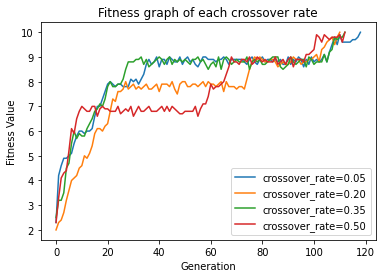

In [13]:
# crossover_rate = 0.05
crossover1_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.05,
    'mutate_rate': 0.20
}
# crossover_rate = 0.20
crossover2_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# crossover_rate = 0.35
crossover3_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.35,
    'mutate_rate': 0.20
}
# crossover_rate = 0.50
crossover4_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 7,
    'crossover_rate': 0.50,
    'mutate_rate': 0.20
}

simulation_times = 300 # simulation times
crossover1_mid_hist = []
crossover2_mid_hist = []
crossover3_mid_hist = []
crossover4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    crossover1_fit_hist = english_test(target, crossover1_parameters)
    crossover2_fit_hist = english_test(target, crossover2_parameters)
    crossover3_fit_hist = english_test(target, crossover3_parameters)
    crossover4_fit_hist = english_test(target, crossover4_parameters)
    
    crossover1_mid_hist.append((crossover1_fit_hist, len(crossover1_fit_hist)))
    crossover2_mid_hist.append((crossover2_fit_hist, len(crossover2_fit_hist)))
    crossover3_mid_hist.append((crossover3_fit_hist, len(crossover3_fit_hist)))
    crossover4_mid_hist.append((crossover4_fit_hist, len(crossover4_fit_hist)))

crossover1_fit_hist = sorted(crossover1_mid_hist, key=lambda x:x[1])[150][0]
crossover2_fit_hist = sorted(crossover2_mid_hist, key=lambda x:x[1])[150][0]
crossover3_fit_hist = sorted(crossover3_mid_hist, key=lambda x:x[1])[150][0]
crossover4_fit_hist = sorted(crossover4_mid_hist, key=lambda x:x[1])[150][0]

plot_result(
    [crossover1_fit_hist,crossover2_fit_hist,crossover3_fit_hist,crossover4_fit_hist],
    'Fitness graph of each crossover rate',
    ['crossover_rate=0.05', 'crossover_rate=0.20', 'crossover_rate=0.35', 'crossover_rate=0.50'],
    'Generation',
    'Fitness Value')

### Additional Experiment - Different K(in tournament selection )

In [ ]:
# k = 3
k1_parameters = {
    'select_type': 'tournament',
    'tournament_k': 3,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# k = 5
k2_parameters = {
    'select_type': 'tournament',
    'tournament_k': 5,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# k = 7
k3_parameters = {
    'select_type': 'tournament',
    'tournament_k': 7,
    'crossover_point': 5,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}
# k = 10
k4_parameters = {
    'select_type': 'tournament',
    'tournament_k': 10,
    'crossover_point': 7,
    'crossover_rate': 0.20,
    'mutate_rate': 0.20
}

simulation_times = 300 # simulation times
k1_mid_hist = []
k2_mid_hist = []
k3_mid_hist = []
k4_mid_hist = []

# simulation
for _ in range(simulation_times):
    target = generate_answer(10, True)
    k1_fit_hist = english_test(target, k1_parameters)
    k2_fit_hist = english_test(target, k2_parameters)
    k3_fit_hist = english_test(target, k3_parameters)
    k4_fit_hist = english_test(target, k4_parameters)
    
    k1_mid_hist.append((k1_fit_hist, len(k1_fit_hist)))
    k2_mid_hist.append((k2_fit_hist, len(k2_fit_hist)))
    k3_mid_hist.append((k3_fit_hist, len(k3_fit_hist)))
    k4_mid_hist.append((k4_fit_hist, len(k4_fit_hist)))

k1_fit_hist = sorted(k1_mid_hist, key=lambda x:x[1])[150][0]
k2_fit_hist = sorted(k2_mid_hist, key=lambda x:x[1])[150][0]
k3_fit_hist = sorted(k3_mid_hist, key=lambda x:x[1])[150][0]
k4_fit_hist = sorted(k4_mid_hist, key=lambda x:x[1])[150][0]

plot_result(
    [k1_fit_hist,k2_fit_hist,k3_fit_hist,k4_fit_hist],
    'Fitness graph of each k in tournament selection',
    ['k=3', 'k=5', 'k=7', 'k=10'],
    'Generation',
    'Fitness Value')